In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

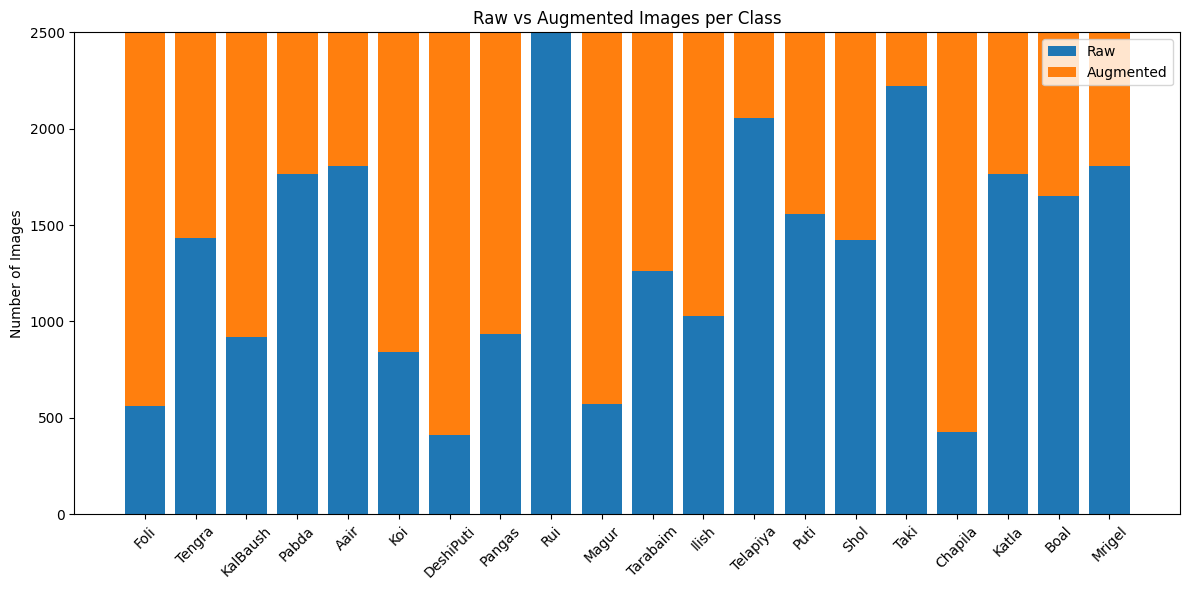

In [1]:
import os
from collections import defaultdict
import matplotlib.pyplot as plt

dataset_path = '/kaggle/input/fishdataset/Fish Data'

class_dirs = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]

class_image_count = defaultdict(lambda: {'Raw': 0, 'Augmented': 0})

for class_name in class_dirs:
    for subfolder in ['Raw', 'Augmented']:
        subfolder_path = os.path.join(dataset_path, class_name, subfolder)
        if os.path.exists(subfolder_path):
            num_images = len([f for f in os.listdir(subfolder_path) if f.endswith(('.jpg', '.png','.jpeg'))])
            class_image_count[class_name][subfolder] = num_images

# Plotting
classes = list(class_image_count.keys())
raw_counts = [class_image_count[c]['Raw'] for c in classes]
aug_counts = [class_image_count[c]['Augmented'] for c in classes]

x = range(len(classes))
plt.figure(figsize=(12, 6))
plt.bar(x, raw_counts, label='Raw')
plt.bar(x, aug_counts, bottom=raw_counts, label='Augmented')
plt.xticks(x, classes, rotation=45)
plt.ylabel('Number of Images')
plt.title('Raw vs Augmented Images per Class')
plt.legend()
plt.tight_layout()
plt.show()

In [2]:
print("Image Count per Class:")
print("{:<20} {:>10} {:>15}".format("Class", "Raw", "Augmented"))
print("-" * 45)

for class_name, counts in class_image_count.items():
    print("{:<20} {:>10} {:>15}".format(class_name, counts['Raw'], counts['Augmented']))

Image Count per Class:
Class                       Raw       Augmented
---------------------------------------------
Foli                        562            1938
Tengra                     1431            1069
KalBaush                    917            1583
Pabda                      1764             736
Aair                       1804             696
Koi                         842            1658
DeshiPuti                   412            2088
Pangas                      934            1566
Rui                        2500               0
Magur                       574            1926
Tarabaim                   1262            1238
Ilish                      1031            1469
Telapiya                   2058             442
Puti                       1560             940
Shol                       1424            1076
Taki                       2223             277
Chapila                     428            2072
Katla                      1765             735
Boal               


Total Raw Images:       26950
Total Augmented Images: 23050
Total All Images:       50000


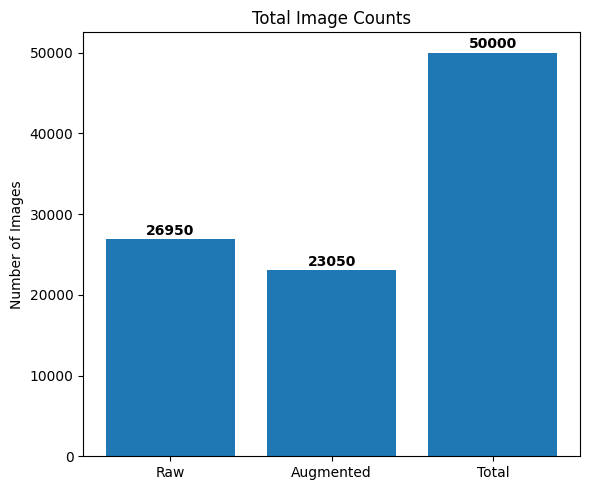

In [3]:
import matplotlib.pyplot as plt

# Count totals
total_raw = sum(counts['Raw'] for counts in class_image_count.values())
total_aug = sum(counts['Augmented'] for counts in class_image_count.values())
total_all = total_raw + total_aug

# Display totals as text
print("\nTotal Raw Images:      ", total_raw)
print("Total Augmented Images:", total_aug)
print("Total All Images:      ", total_all)

# Plotting the total counts
labels = ['Raw', 'Augmented', 'Total']
values = [total_raw, total_aug, total_all]

plt.figure(figsize=(6, 5))
plt.bar(labels, values)
plt.ylabel('Number of Images')
plt.title('Total Image Counts')
for i, v in enumerate(values):
    plt.text(i, v + max(values)*0.01, str(v), ha='center', fontweight='bold')
plt.tight_layout()
plt.show()

In [5]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Input and output directories
INPUT_DIR = '/kaggle/input/fishdataset/Fish Data'
RAW_ONLY_DIR = '/kaggle/working/fish_raw_only'
TRAIN_DIR = '/kaggle/working/fish_raw_train'
VAL_DIR = '/kaggle/working/fish_raw_val'

# Step 1: Extract raw images only
os.makedirs(RAW_ONLY_DIR, exist_ok=True)

for class_name in os.listdir(INPUT_DIR):
    raw_path = os.path.join(INPUT_DIR, class_name, 'Raw')
    if os.path.isdir(raw_path):
        target_dir = os.path.join(RAW_ONLY_DIR, class_name)
        os.makedirs(target_dir, exist_ok=True)
        for fname in os.listdir(raw_path):
            shutil.copy2(os.path.join(raw_path, fname), os.path.join(target_dir, fname))

# Step 2: Split into train/val
for class_name in os.listdir(RAW_ONLY_DIR):
    class_path = os.path.join(RAW_ONLY_DIR, class_name)
    files = os.listdir(class_path)
    train_files, val_files = train_test_split(files, test_size=0.2, random_state=42)

    os.makedirs(os.path.join(TRAIN_DIR, class_name), exist_ok=True)
    os.makedirs(os.path.join(VAL_DIR, class_name), exist_ok=True)

    for f in train_files:
        shutil.copy2(os.path.join(class_path, f), os.path.join(TRAIN_DIR, class_name, f))
    for f in val_files:
        shutil.copy2(os.path.join(class_path, f), os.path.join(VAL_DIR, class_name, f))

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 20

# Data generators
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_gen = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

2025-07-15 19:06:11.993531: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752606372.201198      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752606372.261705      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 21552 images belonging to 20 classes.
Found 5398 images belonging to 20 classes.


In [8]:
# Build model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [9]:
# Train model
model.fit(train_gen, epochs=10, validation_data=val_gen)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1752606477.084350     119 service.cc:148] XLA service 0x7bd940001f80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752606477.085276     119 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1752606478.675349     119 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/674 ━━━━━━━━━━━━━━━━━━━━ 34s 51ms/step - accuracy: 0.0391 - loss: 3.7204   

I0000 00:00:1752606482.381957     119 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


674/674 ━━━━━━━━━━━━━━━━━━━━ 180s 244ms/step - accuracy: 0.6801 - loss: 1.1828 - val_accuracy: 0.9737 - val_loss: 0.1380
Epoch 2/10
674/674 ━━━━━━━━━━━━━━━━━━━━ 153s 227ms/step - accuracy: 0.9833 - loss: 0.1028 - val_accuracy: 0.9867 - val_loss: 0.0716
Epoch 3/10
674/674 ━━━━━━━━━━━━━━━━━━━━ 148s 220ms/step - accuracy: 0.9943 - loss: 0.0467 - val_accuracy: 0.9893 - val_loss: 0.0457
Epoch 4/10
674/674 ━━━━━━━━━━━━━━━━━━━━ 150s 222ms/step - accuracy: 0.9979 - loss: 0.0279 - val_accuracy: 0.9926 - val_loss: 0.0333
Epoch 5/10
674/674 ━━━━━━━━━━━━━━━━━━━━ 148s 220ms/step - accuracy: 0.9989 - loss: 0.0162 - val_accuracy: 0.9926 - val_loss: 0.0301
Epoch 6/10
674/674 ━━━━━━━━━━━━━━━━━━━━ 149s 221ms/step - accuracy: 0.9994 - loss: 0.0108 - val_accuracy: 0.9963 - val_loss: 0.0210
Epoch 7/10
674/674 ━━━━━━━━━━━━━━━━━━━━ 153s 227ms/step - accuracy: 0.9997 - loss: 0.0076 - val_accuracy: 0.9944 - val_loss: 0.0194
Epoch 8/10
674/674 ━━━━━━━━━━━━━━━━━━━━ 148s 220ms/step - accuracy: 0.9995 - loss: 0.00

In [10]:
model.save('/kaggle/working/fish_model_resnet50.h5')

In [11]:
loss, accuracy = model.evaluate(val_gen)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy*100:.2f}%")

169/169 ━━━━━━━━━━━━━━━━━━━━ 30s 179ms/step - accuracy: 0.9946 - loss: 0.0204
Validation Loss: 0.0253
Validation Accuracy: 99.37%


169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 214ms/step
              precision    recall  f1-score   support

        Aair       0.98      1.00      0.99       361
        Boal       1.00      0.98      0.99       331
     Chapila       1.00      1.00      1.00        86
   DeshiPuti       1.00      1.00      1.00        83
        Foli       1.00      1.00      1.00       113
       Ilish       1.00      0.99      1.00       207
    KalBaush       0.96      1.00      0.98       184
       Katla       1.00      0.99      0.99       353
         Koi       1.00      1.00      1.00       169
       Magur       1.00      1.00      1.00       115
      Mrigel       0.98      1.00      0.99       362
       Pabda       1.00      0.99      1.00       353
      Pangas       1.00      1.00      1.00       187
        Puti       1.00      1.00      1.00       312
         Rui       0.99      0.98      0.99       500
        Shol       0.99      0.99      0.99       285
        Taki       1.00      0.99    

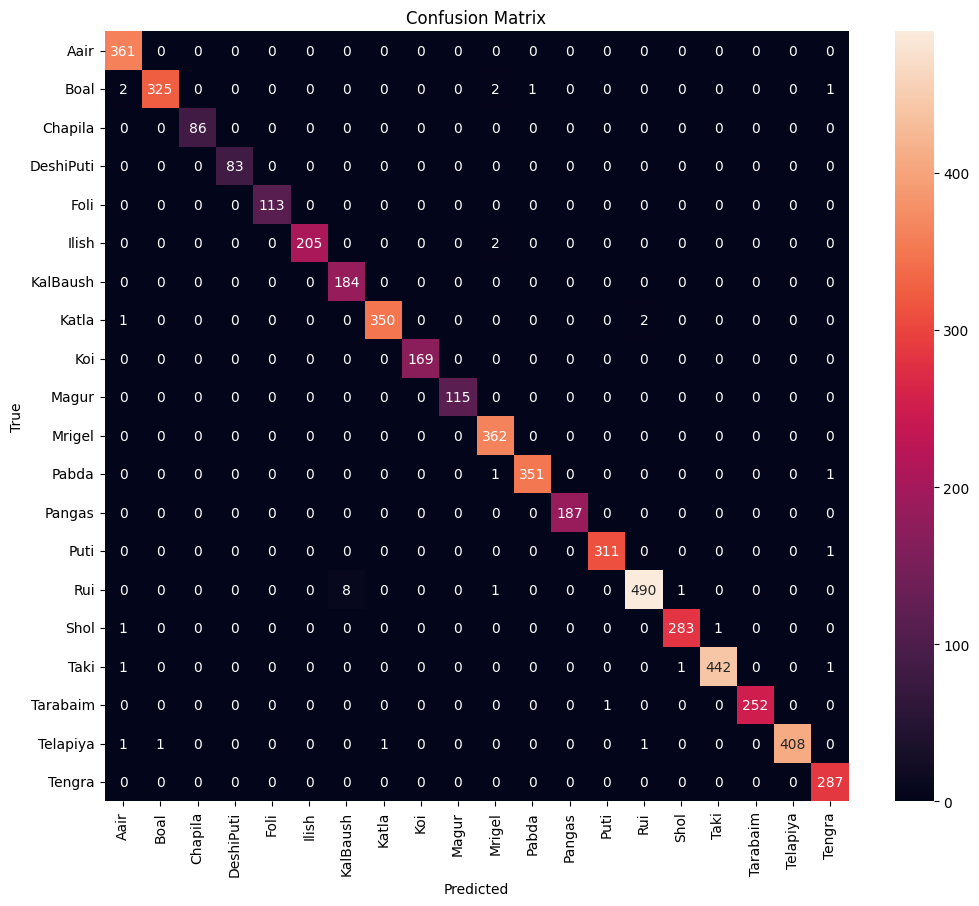

In [12]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict classes
y_pred_probs = model.predict(val_gen)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = val_gen.classes
class_labels = list(val_gen.class_indices.keys())

# Classification report
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()